# Learning Ergodic Properties of Chaotic Attractors and Estimating Lyapunov Exponents From Data

This notebook reproduces some results from the paper "Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data", https://doi.org/10.1063/1.5010300 for the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) which is a system of three coupled ordinary differential equations exhibiting aperiodicity and sensitivity to initial values.
In the paper it was demonstrated that reservoir computing can be used to predict the future of a trajectory of a chaotic system up to 1000 time units which were never seen during the training.

I demonstrate that a feed forward network with sufficient capacity or a decision tree based regressor can be used to predict future trajectories and ergodic properties of the Lorenz system.

For certain properties, predictions beyond several Lyapunov times can be obtained with good accuracy.
At first glance this seems surprising since the Lorenz system is chaotic.

In [1]:
import gzip
import os
import pickle
import scipy
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## The Lorenz System with Lorenz63 parameters

In [2]:
t_start = 0
t_end = 40
# canonical Lorenz63 parameters resulting in a compact chaotic attractor
a = 10
b = 28
c = 8.0/3.0

initial_values = np.array([2, 3, 4])+np.random.normal(size=3)  # [x,y,z]
# r=[x,y,z]


def rhs(s, r):
    return [a*(r[1]-r[0]), r[0]*(b-r[2])-r[1], r[0]*r[1]-c*r[2]]


def event(t, y):
    return y[0]


pertubation_amplitude = np.finfo(float).eps**(1.0/2.0)  # on the order of 1e-9

NUM_EXPORTED_T = 1000


def get_res_for_inital_conditions(initial_values, t_start, t_end, t_start_export):
    global NUM_EXPORTED_T
    exported_times = np.linspace(t_start_export, t_end, num=NUM_EXPORTED_T)
    # note that we need to solve the system of coupled ordinary differential equations with quite small tolerances
    res = solve_ivp(rhs, (t_start, t_end), initial_values,
                    events=event, t_eval=exported_times, atol=1e-14, rtol=1e-13)
    return res


res = get_res_for_inital_conditions(initial_values, t_start, t_end, t_start)
res_pertubation_x = get_res_for_inital_conditions(
    initial_values+np.array([pertubation_amplitude, 0, 0]), t_start, t_end, t_start)
res_pertubation_y = get_res_for_inital_conditions(
    initial_values+np.array([0, pertubation_amplitude, 0]), t_start, t_end, t_start)
res_pertubation_z = get_res_for_inital_conditions(
    initial_values+np.array([0, 0, pertubation_amplitude]), t_start, t_end, t_start)

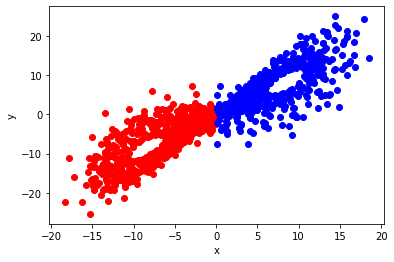

In [3]:
# the solution res.y is [[x1,y1,z1],...] for each timestamp
# the solution is symmetric in z
mask = res.y[0] < 0
plt.scatter(res.y[0][mask], res.y[1][mask], c="red")
plt.scatter(res.y[0][~mask], res.y[1][~mask], c="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Perturbed Trajectories and Biggest Lyapunov Exponent

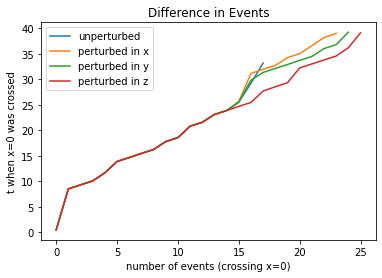

In [4]:
plt.title("Difference in Events")
plt.plot(np.array(res.t_events).flatten(), label="unperturbed")
plt.plot(np.array(res_pertubation_x.t_events).flatten(), label="perturbed in x")
plt.plot(np.array(res_pertubation_y.t_events).flatten(), label="perturbed in y")
plt.plot(np.array(res_pertubation_z.t_events).flatten(), label="perturbed in z")
plt.ylabel("t when x=0 was crossed")
plt.xlabel("number of events (crossing x=0)")
plt.legend()
plt.show()

The largest Lyapunov exponent can be computed from fitting an exponential to the difference in slightly perturbed trajectories. In literature, this method is discussed as "(unrescaled) deviation vector method", see "Lyapunov exponents in constrained and unconstrained ordinary differential equations" https://arxiv.org/pdf/physics/0303077.pdf .

Text(0, 0.5, 'difference')

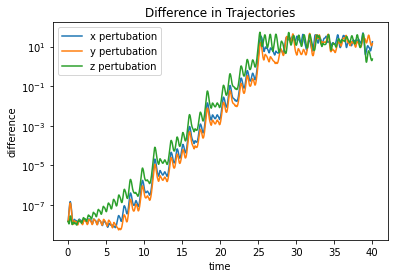

In [5]:
plt.title("Difference in Trajectories")
plt.plot(np.array(res_pertubation_x.t), np.linalg.norm(
    res_pertubation_x.y-res.y, axis=0), label="x pertubation")
plt.plot(np.array(res_pertubation_y.t), np.linalg.norm(
    res_pertubation_y.y-res.y, axis=0), label="y pertubation")
plt.plot(np.array(res_pertubation_z.t), np.linalg.norm(
    res_pertubation_z.y-res.y, axis=0), label="z pertubation")
plt.yscale('log')
plt.legend()
plt.xlabel("time")
plt.ylabel("difference")

Lyapunov Exponent (the bigger, the faster the trajectories diverge)
0.8249973933919025
Lyapunov Time (after which the system becomes chaotic)
1.2121250418605447


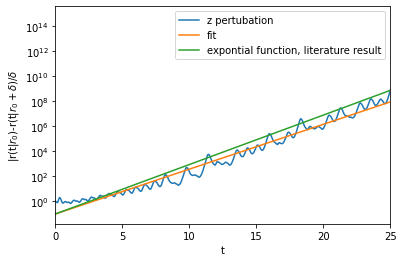

In [6]:
def lin(t, a, b):
    return a*t+b


def compute_lyapunov_deviation(res, res_pertubation):
    global pertubation_amplitude
    return np.linalg.norm(interp1d(res_pertubation.t, res_pertubation.y)(res.t)-res.y, axis=0)/pertubation_amplitude


# in the (unrescaled) deviation vector method the fit needs to be constrained because the difference in trajectories saturates for an attractor
mask = np.logical_and(res.t > 0, res.t < 24)
popt, pcov = curve_fit(lin, res.t[mask], np.log(
    (compute_lyapunov_deviation(res, res_pertubation_z))[mask]))

# compute_lyapunov_exponent using the "(unrescaled) deviation vector method"
plt.plot(res.t, compute_lyapunov_deviation(
    res, res_pertubation_z), label="z pertubation")
plt.plot(res.t, np.exp(res.t * popt[0]+popt[1]), label="fit")
# compare to https://aip.scitation.org/doi/10.1063/1.5010300
plt.plot(res.t, np.exp(res.t * 0.91+popt[1]),
         label="expontial function, literature result")
plt.yscale('log')
plt.xlim([0, 25])
plt.xlabel("t")
plt.ylabel(r"|r(t|$r_0$)-r(t|$r_0+\delta$)/$\delta$")
plt.legend()
print("Lyapunov Exponent (the bigger, the faster the trajectories diverge)")
print(popt[0])
lyapunov_time_fit = 1/popt[0]
print("Lyapunov Time (after which the system becomes chaotic)")

print(lyapunov_time_fit)

We note that the fitted Lyapunov exponent is more or less close to the biggest Lyapunov exponent as it is reported in literature (0.91), compare https://doi.org/10.1063/1.5010300 . Averaging over multiple initial values and pertubations could have improved our result.

# Generating/Loading Training Data

We generate training data via solving the coupled system of ordinary differential equations with the Runge–Kutta–Fehlberg method (RK45) which is the default method in scipys solve_ivp. The generation of the training data takes a while due to the high required accuracy for reproducing the Lyapunov exponent.

In [7]:
# We construct NUM_INITIAL_VALUES_PER_COORDINATE**3 trajectories starting from NUM_INITIAL_VALUES_PER_COORDINATE**3 coordinates
# set NUM_INITIAL_VALUES_PER_COORDINATE=3 if it needs to be faster, but note that the success of the training depends on enough training data
NUM_INITIAL_VALUES_PER_COORDINATE = 8
filename = "training_data_{}.pklz".format(NUM_INITIAL_VALUES_PER_COORDINATE)
if not os.path.exists(filename):
    t_start_train = 0
    t_end_train = 30
    t_start_test = t_end_train+3*lyapunov_time_fit
    t_end_test = t_start_test+30
    training_data = []
    test_data = []
    initial_values = []
    # np.linspace(0, 10, num=NUM_INITIAL_VALUES_PER_COORDINATE):
    for initial_x in 10*2*(np.random.random(size=NUM_INITIAL_VALUES_PER_COORDINATE)-0.5):
        for initial_y in 10*2*(np.random.random(size=NUM_INITIAL_VALUES_PER_COORDINATE)-0.5):
            for initial_z in 10*2*(np.random.random(size=NUM_INITIAL_VALUES_PER_COORDINATE)-0.5):
                initial_values.append([initial_x, initial_y, initial_z])
                res_train = get_res_for_inital_conditions(
                    initial_values[-1], t_start_train, t_end_train, t_start_train)
                res_test = get_res_for_inital_conditions(
                    initial_values[-1]+2*(2*(np.random.random(3)-0.5)), t_start_train, t_end_test, t_start_test)
                training_data.append(
                    [np.diff(res_train.t.flatten()), res_train.y.T])
                test_data.append([np.diff(res_test.t.flatten()), res_test.y.T])

    fp = gzip.open(filename, 'wb')
    pickle.dump([initial_values, training_data, test_data], fp)
    fp.close()
else:
    print("reading training data")
    fp = gzip.open(filename, 'rb')
    initial_values, training_data, test_data = pickle.load(fp)

reading training data


In [8]:
# package data in x_train and y_train
# the feature vectors in x_train shall contain a history of the past "len_delay_in_feature_vector" (e.g. 40) timesteps

x_test = []
y_test = []
# number of features in the feature vector, can be as high as e.g. 100
len_delay_in_feature_vector = 40
deltaT_between_samples = 30.0/NUM_EXPORTED_T


def construct_buffer(training_data, initial_values):
    global len_delay_in_feature_vector
    x_train = []
    y_train = []
    for i in range(len(initial_values)):
        if len(training_data[i][0]) > 200:
            for timestamp_i in range(len_delay_in_feature_vector, len(training_data[i][0])-len_delay_in_feature_vector):
                feature_vector = []
                feature_vector.extend(
                    training_data[i][1][timestamp_i-len_delay_in_feature_vector:timestamp_i].flatten())  # x,y,z in past
                x_train.append(feature_vector)
                y_train.append(training_data[i][1][timestamp_i].flatten())
    return np.array(x_train), np.array(y_train)


x_train, y_train = construct_buffer(training_data, initial_values)
x_test, y_test = construct_buffer(test_data, initial_values)
print("shape training dataset feature vectors", x_train.shape)
print("shape test dataset feature vectors", x_test.shape)
print("shape training dataset labels", y_train.shape)

shape training dataset feature vectors (470528, 120)
shape test dataset feature vectors (470528, 120)
shape training dataset labels (470528, 3)


# Training the Model

We will use a feed forward neural net to predict the trajectory of the Lorenz system. The network needs enough capacity to generalize but not too much to exhibit high variance. A network with 2 hidden layers of size 150 and 60 turned out to give "oK" results. A hyperparameter search could give better parameters.

In [9]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(60, 70),
                     learning_rate="adaptive", early_stopping=True)

Note, we could also use other machine learning models which are universal function approximators. For example we could use decision trees. You can try to run the commented code below and see the results. The decieion tree model can reproduce the "climate" of the Lorenz attractor, but fails in reproducing the Lyapunov exponents since it trains piece wise constant decision trees which are not well suited to investigate infinitesimal changes to input prameters

In [10]:
#from xgboost import XGBRegressor
#from sklearn.multioutput import MultiOutputRegressor
#model = MultiOutputRegressor(XGBRegressor())

In [11]:
model.fit(x_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(60, 70),
             learning_rate='adaptive')

## Testing with successively building up Feature Vectors from the ML model itself: Comparing the Machine Learned Model with Numerical Solutions
Next we generate a new time series for initial conditions unseen in the training with our machine learned model. In contrast to before we now use the ML model itself to generate the feature vectors (containing the last state of the system). This allows to use the ML model for predictions into the future without having to rely on the exact numerical solutions.

In [12]:
def generate_new_input_example(t_start_train=0, t_end_train=30, initial_condition=np.random.random(size=3)*7):
    training_data = []
    res_train = get_res_for_inital_conditions(
        initial_condition, t_start_train, t_end_train, t_start_train)
    training_data.append([np.diff(res_train.t.flatten()), res_train.y.T])
    x_train, y_train = construct_buffer(training_data, [initial_condition])
    # overwrite numeric solution and initial value because the initial value of the buffer is different
    initial_condition = y_train[0]
    res_train = get_res_for_inital_conditions(
        initial_condition, t_start_train, t_end_train, t_start_train)
    return x_train[0], res_train, initial_condition


initial_condition = np.random.random(size=3)*7
# Note you could also recursively apply the ML model for e.g. initial_condition=initial_values[0]
# You would observe that the newly computed trajectory from recursively applying the ML model diverges from the numerical solution faster than
# the ML model which gets the numerically computed feature vectors as input (i.e. not via recursive application of the ML model).
# This is due to propagation of error.
x_new, numeric_solution, initial_condition = generate_new_input_example(
    initial_condition=initial_condition)
x_new = np.expand_dims(x_new, 1).T


def compute_model_trajectory(model, initial_feature_vector, num_exported_t=NUM_EXPORTED_T):
    new_initial_feature_vector = copy.deepcopy(initial_feature_vector)
    results = []
    for i in range(num_exported_t):
        result = model.predict(new_initial_feature_vector)
        results.append(copy.deepcopy(result[0]))
        new_initial_feature_vector[0] = np.roll(
            new_initial_feature_vector[0], -3)
        new_initial_feature_vector[0][len(
            new_initial_feature_vector[0])-3:len(new_initial_feature_vector[0])] = result[0]
    return np.array(results)


ML_results = compute_model_trajectory(model, x_new, 10*1000)

The machine learned trajectory and the numerical solution look like this in the x-z plane. Over time, differences accumulate.

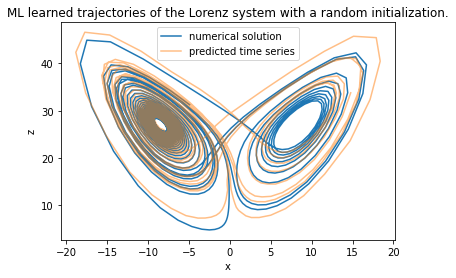

In [13]:
plt.plot(numeric_solution.y.T[:, 0],
         numeric_solution.y.T[:, 2], label="numerical solution")
plt.plot(ML_results[:1000, 0], ML_results[:1000, 2],
         label="predicted time series", alpha=0.5)
plt.legend()
plt.title(
    "ML learned trajectories of the Lorenz system with a random initialization.")
plt.xlabel("x")
plt.ylabel("z")
plt.show()

We can also compare single components of the trajectory and their differences:

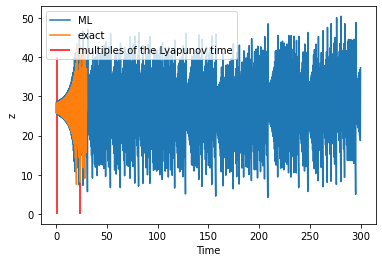

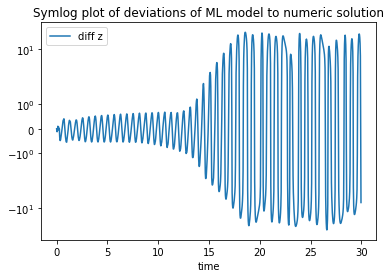

In [14]:
idx_to_xyz = {0: "x", 1: "y", 2: "z"}
idx = 2  # may take the values 0,1,2 for x,y,z
# 30 is the prediciton horizon, NUM_EXPORTED_T the number of exported points in get_res_for_initial_conditions

plt.plot(deltaT_between_samples *
         np.arange(ML_results[:, idx].shape[0]), ML_results[:, idx], label="ML")
# compute numerical solution
numerical_solution = get_res_for_inital_conditions(ML_results[0], 0, 30, 0)
plt.plot(deltaT_between_samples *
         np.arange(numerical_solution.y.T[:, idx].shape[0]), numerical_solution.y.T[:, idx], label="exact")
plt.vlines([lyapunov_time_fit, 19*lyapunov_time_fit], ymin=0,
           ymax=40, label="multiples of the Lyapunov time", color="red")
plt.xlabel("Time")
plt.ylabel("{}".format(idx_to_xyz[idx]))
plt.legend()
plt.show()


times = deltaT_between_samples*np.arange(numerical_solution.y.T.shape[0])
plt.title("Symlog plot of deviations of ML model to numeric solution")
len_numerical_solution = numerical_solution.y.T.shape[0]
plt.plot(times, numerical_solution.y.T[:, idx]-ML_results[:len_numerical_solution,
         idx], label="diff {}".format(idx_to_xyz[idx]))
plt.yscale('symlog')
plt.legend()
plt.xlabel("time")
plt.show()

We observe that the error builds up over time due to propagation of error, resulting in the following distribution of errors:

Text(0, 0.5, 'density')

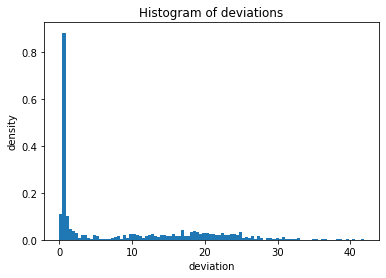

In [15]:
plt.title("Histogram of deviations")
plt.hist(np.linalg.norm(ML_results[:len_numerical_solution] -
         numerical_solution.y.T, axis=1), density=True, label="", bins=100)
plt.xlabel("deviation")
plt.ylabel("density")

Essentially, the ML model fails to reproduce the exact trajectory but produces a similar looking trajectory with "smaller" deviations in the beginning.

Next we examine the return map in the z coordinate and comare it to Figure 3 in https://doi.org/10.1063/1.5010300 .
The feed forward neural network can reproduce the return map (with some errors).

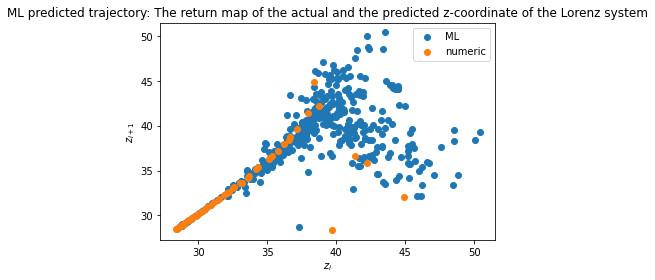

In [35]:
def get_local_maxima(array):
    return array[np.logical_and(np.roll(array, -1) < array, (np.roll(array, 1) < array))]


ML_maxima = get_local_maxima(ML_results[:, 2])
numeric_solutio_maxima = get_local_maxima(numeric_solution.y.T[:, 2])
plt.scatter(ML_maxima, np.roll(ML_maxima, -1), label="ML")
plt.scatter(numeric_solutio_maxima, np.roll(
    numeric_solutio_maxima, -1), label="numeric")
plt.xlabel(r"$z_i$")
plt.ylabel(r"$z_{i+1}$")
plt.legend()
plt.title("ML predicted trajectory: The return map of the actual and the predicted z-coordinate of the Lorenz system")

Next, we try to estimate the Lyapunov exponent soley from the ML model which was trained on the training data.
For this we compute NUM_INDEPENDEN_FITS perturbed trajectories.

In [31]:
# note not working for decision trees which approximate functions to be piecewise constant (try this only with the neural net)
def compute_perturbed_trajectory_from_model(model, initial_condition=np.random.random(size=3)*10):
    global pertubation_amplitude
    perturbed_initial_condition = copy.deepcopy(initial_condition)
    perturbed_initial_condition[0] += pertubation_amplitude
    x = np.expand_dims(generate_new_input_example(
        initial_condition=initial_condition)[0], 1).T
    x_perturbed = np.expand_dims(generate_new_input_example(
        initial_condition=perturbed_initial_condition)[0], 1).T
    y = compute_model_trajectory(model, x)
    y_perturbed = compute_model_trajectory(model, x_perturbed)
    return y, y_perturbed


lyapunov_deviations = []
ts = []
lyapunov_exponents = []
interceptions = []

NUM_INDEPENDEN_FITS = 10  # the more the lower will be the standard error
for i in range(NUM_INDEPENDEN_FITS):
    y, y_perturbed = compute_perturbed_trajectory_from_model(
        model, np.random.random(size=3)*10)
    ts = np.arange(NUM_EXPORTED_T)*deltaT_between_samples
    mask = np.logical_and(ts > 0, ts < 24)
    lyapunov_deviation = np.linalg.norm(
        y_perturbed-y, axis=1)/pertubation_amplitude
    lyapunov_deviations.append(lyapunov_deviation)
    popt, pcov = curve_fit(lin, ts[mask], np.log(lyapunov_deviation)[mask])
    lyapunov_exponents.append(popt[0])
    interceptions.append(popt[1])

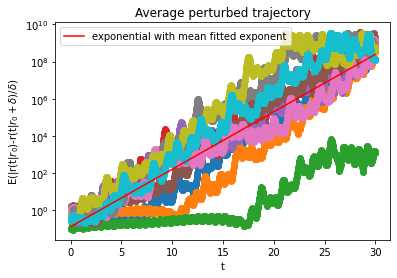

In [32]:
lyapunov_deviations = np.array(lyapunov_deviations)
mean_lyapunov_exponent = np.mean(lyapunov_exponents)

for i in range(len(lyapunov_deviations)):
    plt.scatter(ts, lyapunov_deviations[i])
plt.yscale("log")

plt.title("Average perturbed trajectory")
plt.plot(ts, np.exp(mean_lyapunov_exponent*ts+np.mean(interceptions)),
         label="exponential with mean fitted exponent", color="red")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"E(|r(t|$r_0$)-r(t|$r_0+\delta$)/$\delta$)")
plt.show()

In [34]:
print("Mean Lyaponv exponent fitted to the ML model trajectories {} (Median {}) +/- {}".format(mean_lyapunov_exponent,
      np.median(lyapunov_exponents),  1.96*np.std(lyapunov_exponents, ddof=1)/np.sqrt(NUM_INDEPENDEN_FITS)))

Mean Lyaponv exponent fitted to the ML model trajectories 0.7113034659295632 (Median 0.7367492061222628) +/- 0.13413611092594685


# Conclusion

Some of the results outlined in  "Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data", https://doi.org/10.1063/1.5010300 could be reproduced with a simple feed forward network, however, the results depend critically on the choice of hyper parameters like the hidden layer sizes and the size of the training set. It could also be interesting to train a recurrent neural net with long short-term memory.